In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 

(CVXPY) Mar 27 09:36:51 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 27 09:36:51 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

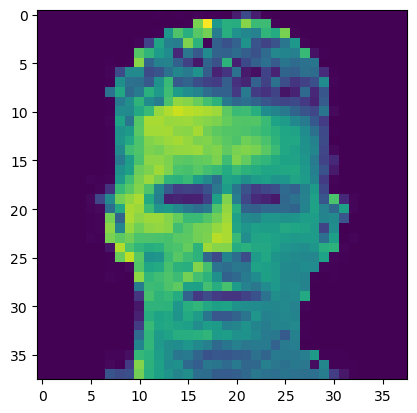

In [3]:
plt.imshow(X)

In [4]:
Y = np.fft.fft2(X)

In [5]:
width, height = Y.shape

In [6]:
y = Y.flatten()

In [7]:
y.shape

(1444,)

In [8]:
Yz = Y.copy()
Yz[np.abs(Yz) < 1000] = 0.

In [9]:
np.count_nonzero(Yz.real)

527

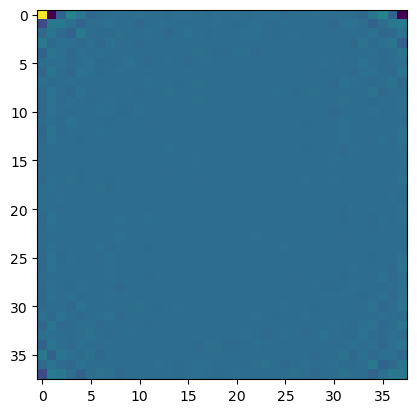

In [10]:
plt.imshow(Yz.real)

In [11]:
yz = Yz.flatten()

In [12]:
dim = yz.size

In [13]:
# A = np.random.randint(0,2,size=(1444//2,1444))
# A.shape

In [14]:
# A = np.random.randint(0,2,size=(1444//2,1444))
square_size = 2
yul = Yz[:square_size, :square_size]
yur = Yz[:square_size, -square_size:]
yll = Yz[-square_size:, :square_size]
ylr = Yz[-square_size:, -square_size:]

corners = np.block([[yul, yur],
              [yll, ylr]])

In [15]:
corners_flat = corners.flatten()

In [16]:
stacked_corners = np.tile(corners_flat, 4)
stacked_corners = stacked_corners[:dim]
stacked_corners.shape

(64,)

In [17]:
stacked_corners.shape

(64,)

In [18]:
yz.shape

(1444,)

In [19]:
num_rows_corners = stacked_corners.shape[0]
size_of_A = (dim//2)*dim

# sampled_indices = np.random.randint(0, num_rows_corners, size=size_of_A)
sampled_indices = np.random.randint(0, size_of_A, size=size_of_A//10)

# Create the new matrix by sampling rows from corners using the generated indices
# A = stacked_corners[sampled_indices]
# b = stacked_corners[sampled_indices]
# A = np.zeros(size_of_A)
# A[sampled_indices] = 1.
# A.reshape(722,1444)
# b = A@yz
A = np.zeros(size_of_A)
A[sampled_indices] = 1.
A = A.reshape(dim//2,dim)
yz = yz.reshape((-1, 1))

#A = A.reshape(722,1444)
#A.shape

In [20]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
# stacked_corners.shape

In [22]:
b = A@yz

In [23]:
ysparsereal = cvx.Variable(dim)
ysparsereal = ysparsereal.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [24]:
ysparseimag = cvx.Variable(dim)
ysparseimag = ysparseimag.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [25]:
ysparse = ysparsereal.value + ysparseimag.value*1j

In [26]:
Ysparse = ysparse.reshape((width,height))

In [27]:
np.count_nonzero(Ysparse.real.round(6))

1243

In [28]:
Xhat = np.fft.ifft2(Ysparse).real

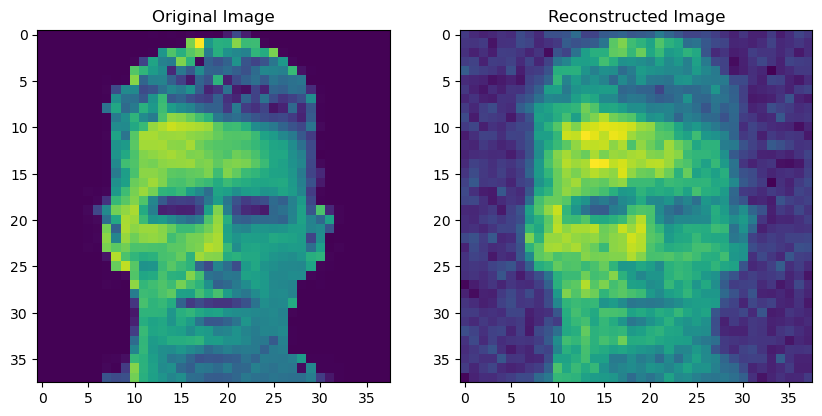

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Xhat)
plt.title('Reconstructed Image')

plt.show()

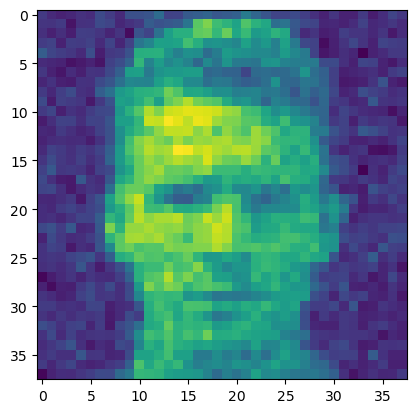

In [30]:
plt.imshow(Xhat)

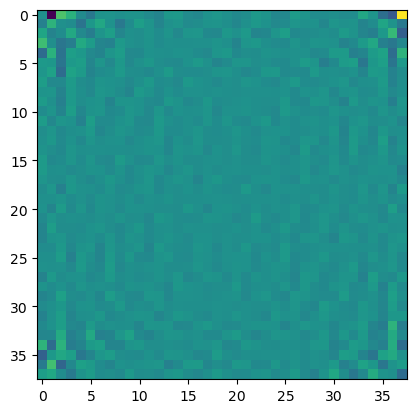

In [31]:
plt.imshow(Y.imag)